_This notebook contains code and comments from Section 5.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 5.2 Gradient Boosting: Gradient Descent + Boosting
Gradient boosting combines gradient descent and boosting. Instead of computing the overall true gradient explicitly, gradient boosting aims to **approximate the true gradient** with a weak learner. 

Let's begin by generating a simple two-dimensional to visualize how gradient descent works step-by-step.

In [1]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.15, random_state=13)
y = 2 * y - 1

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from plot_utils import plot_2d_data, plot_2d_classifier

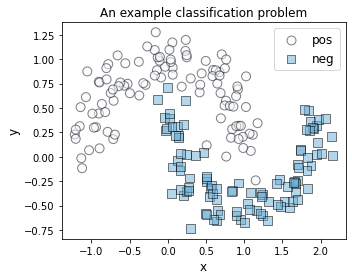

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2d_data(ax, X, y, xlabel='x', ylabel='y', s=80, alpha=0.3,
             title='An example classification problem', 
             legend=['pos', 'neg'], colormap='Blues')
fig.tight_layout()

We'll use the same loss function as in Sec. 5.2: the squared loss, as well as its gradient. The squared loss is defined slightly differently: it takes the true labels $\mathbf{y}$ and predicted labels $f$. This is because, unlike the previous example, where we assumed a linear classifier, here $f$ can be any classifier.

Recall the definition of the loss function, which is defined over the **entire training set of $n$ training examples**:
\\[
L(w_1, w_2) = \frac{1}{2} \sum_{i=1}^n \left( y_i - f(\mathbf{x}_i) \right)^2.
\\]

For a single training example $\mathbf{x}_i$:
\\[
L(w_1, w_2; \mathbf{x}_i) = \frac{1}{2} \left( y_i - f(\mathbf{x}_i) \right)^2.
\\]

Now, we can compute the **gradient** of the loss function: the gradient of $L(w_1, w_2; \mathbf{x}_i)$ with respect to $f(\mathbf{x}_i)$:
\\[
g(w_1, w_2) = \frac{\partial L(w_1, w_2; \mathbf{x}_i)}{\partial f(\mathbf{x}_i)}
    = -(y_i - f(\mathbf{x}_i))
\\]

The gradient is simply the difference between the true and predicted labels, which is also known as the **residual**. Training examples that are badly misclassified will have large functional gradients as the gap between the true and predicted labels will be large. Training examples that are correctly classified will have small functional gradients.

Let's say that our classifier is $f(\mathbf{x}_i) = 0.5$. This is a terrible classifier that can't decide if the training examples belong to the positive class ($y_i = 1$) or the negative class ($y_i=0$) as it always returns $0.5$ for all inputs.

The gradients, or the residuals, can be computed for each data point.

In [4]:
import numpy as np
f = np.full((len(y), ), fill_value=0.0)
residuals = -(y - f)

For positive examples, we have that the **negative** residual $r_i = y_i - f(\mathbf{x}_i) = 1 - 0 = +1$. This residual suggests that the classification of the positive examples can be improved by pushing the model by towards $1$. For negative examples, $r_i = y_i - f(\mathbf{x}_i) = -1 - 0 = -1$, which suggests that the classification of the negative examples can be improved by pushing the model by away from $1$ and towards $-1$.

The residual ($r_i$) is a measure of how badly a particular training example is misclassified. This is similar to the weight ($D_i$) of training examples in AdaBoost, which also represented how badly a training example was misclassified. 

Again, similar to AdaBoost, we will train a weak learner. In AdaBoost, we used weighted training examples $(\mathbf{x}_i, y_i, D_i)$ to train a weak classifier. In gradient boosting, we will use training examples and residuals $(\mathbf{x}_i, r_i)$ to train a **weak regressor**. 

In [5]:
from sklearn.tree import DecisionTreeRegressor
h = DecisionTreeRegressor(max_depth=1)
h.fit(X, -residuals)  # Observe the negated residuals: we want to approximate the negative gradient

DecisionTreeRegressor(max_depth=1)

This weak regressor is an approximate gradient as it was fit to residuals, which are the **pointwise gradients**.


### 5.2.1 Intuition: Learning with residuals
The key component of sequential ensemble methods, such as AdaBoost and gradient boosting, is that they aim to train a new weak estimator at each iteration to fix the errors made by the weak estimator at the previous iteration. However, AdaBoost and gradient boosting train new weak estimators on poorly classified examples in rather different ways.

In contrast, gradient boosting uses residuals or errors (between the true and predicted labels) to tell the base learning algorithm which training examples it should focus on in the next iteration. 

What exactly is a residual? For a training example, it is simply the error between the true label and the corresponding prediction. Intuitively, a correctly classified example must have a small residual and a misclassified example must have a large residual.

More concretely, if a classifier $h$ makes a prediction $h(x)$ on a training example $x$, we often measure the quality of the prediction using a **loss function**. Let's say we use the squared loss

$$loss(true, predicted) = \frac{1}{2} (true - predicted)^2 = \frac{1}{2} (y - h(x))^2.$$

The resisual then, is simply the negative gradient of the loss function:

$$ residual(true,predicted) = true - predicted = y-h(x).$$

In the example below, we inspect gradient boosting iterations to see what these residuals (measured according to the squared loss functions) look like, and visualize the corresponding weak learners trained by gradient boosting. 

**NOTE**: Different loss functions lead to different residuals, since their gradients will be different. Gradient boosting can handle many such loss functions, which makes it a general approach to learning several different types of classification, regression, ranking problems and many more!

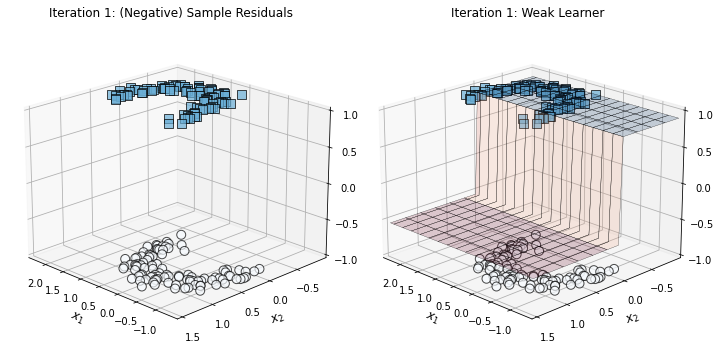

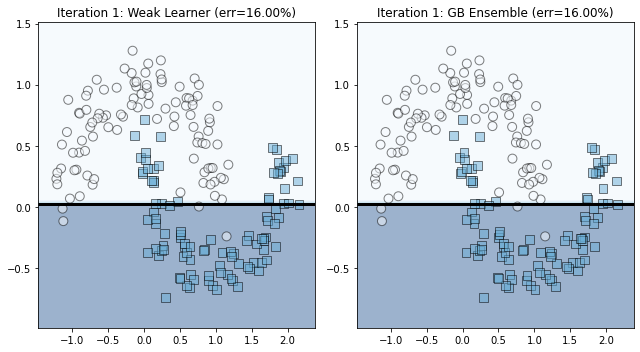

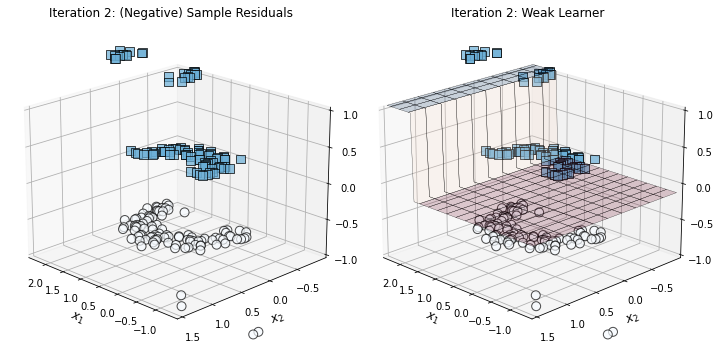

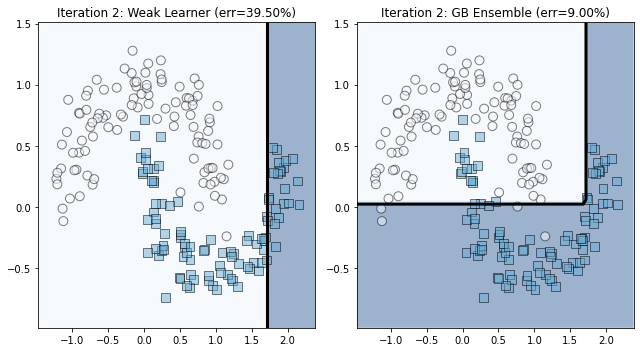

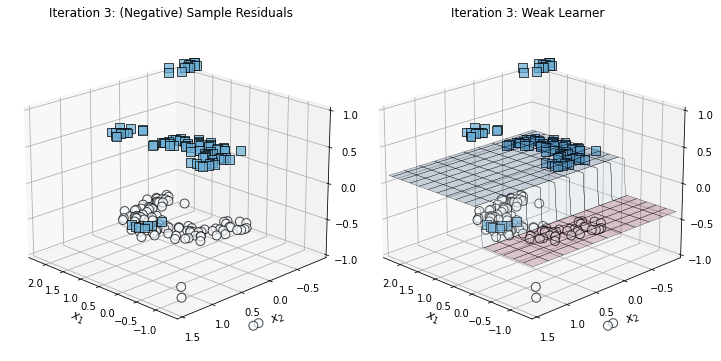

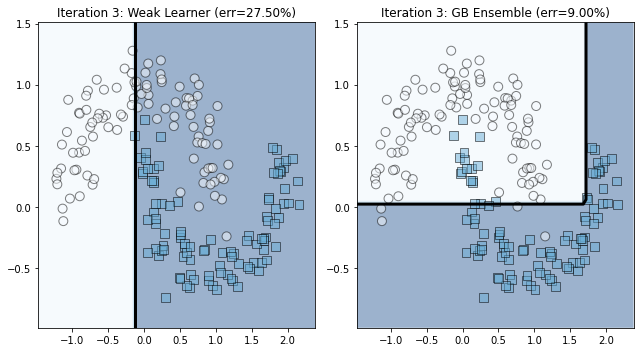

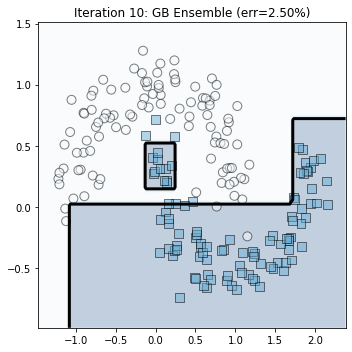

In [6]:
from scipy.optimize import minimize_scalar
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm
import matplotlib.colors as col

# Set up a mesh for 3d plotting
xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05), 
                           np.arange(yMin, yMax, 0.05))

cmap = cm.get_cmap('Blues')
colors = cmap(np.linspace(0, 0.5, num=2))
# views = [(36, 118), (48, -116), (11, 108)]
views = [(20, 135), (20, 135), (20, 135)]


# Initialize
n_samples, n_features = X.shape
n_estimators = 10
ensemble = []
F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble

for t in range(n_estimators):
    # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
    residuals = y - F
    h = DecisionTreeRegressor(max_depth=1)
    h.fit(X, residuals)

    # ----------------------------------------------    
    # Visualize the residuals and their fit in 3d
    if t in [0, 1, 2]:
        fig = plt.figure(figsize=(10, 5))
        
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        ax.view_init(elev=views[t][0], azim=views[t][1])
        ax.scatter(X[y<0, 0], X[y<0, 1], residuals[y<0], c=col.rgb2hex(colors[0]), 
                   marker='o', s=80, edgecolors='k', alpha=0.7)
        ax.scatter(X[y>0, 0], X[y>0, 1], residuals[y>0], c=col.rgb2hex(colors[1]), 
                   marker='s', s=80, edgecolors='k', alpha=0.7)
        ax.set_xlabel('$x_1$', fontsize=12)
        ax.set_xlim(xMin, xMax)
        ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_ylim(yMin, yMax)
        # ax.set_zlabel('Negative Residuals')
        ax.set_zlim(-1, 1)
        ax.set_zticks([-1., -0.5, 0.0, 0.5, 1.])
        ax.set_title('Iteration {0}: (Negative) Sample Residuals '.format(t + 1), fontsize=12)

        ax = fig.add_subplot(1, 2, 2, projection='3d')
        zMesh = h.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
        zMesh = zMesh.reshape(xMesh.shape)
        ax.plot_surface(xMesh, yMesh, zMesh, rstride=5, cstride=5, 
                        alpha=0.2, linewidth=0.25, edgecolors='k', cmap='RdBu')
        ax.view_init(elev=views[t][0], azim=views[t][1])
        ax.scatter(X[y<0, 0], X[y<0, 1], residuals[y<0], c=col.rgb2hex(colors[0]), 
                   marker='o', s=80, alpha=0.7, edgecolors='k')
        ax.scatter(X[y>0, 0], X[y>0, 1], residuals[y>0], c=col.rgb2hex(colors[1]), 
                   marker='s', s=80, alpha=0.7, edgecolors='k')
        ax.set_xlabel('$x_1$', fontsize=12)
        ax.set_xlim(xMin, xMax)
        ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_ylim(yMin, yMax)
        # ax.set_zlabel('Negative Residuals')
        ax.set_zlim(-1, 1)
        ax.set_zticks([-1., -0.5, 0.0, 0.5, 1.])
        ax.set_title('Iteration {0}: Weak Learner'.format(t + 1), fontsize=12)

        
        fig.tight_layout()
#         plt.savefig('./figures/CH05_F{0:2d}_Kunapuli.png'.format(2*t + 11), format='png',
#                     dpi=300, bbox_inches='tight')
#         plt.savefig('./figures/CH05_F{0:2d}_Kunapuli.pdf'.format(2*t + 11), format='pdf',
#                     dpi=300, bbox_inches='tight')
    # ----------------------------------------------   

    # Compute a step length that produces the best improvement in the loss
    hreg = h.predict(X)
    loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
    step = minimize_scalar(loss, method='golden')
    a = step.x
      
    # Compute the error of the new classifier
    F += a * hreg
    
    # Update the ensemble
    ensemble.append((a, h))
    
    # ----------------------------------------------   
    # Plot the classification of the weak learner and the overall ensemble
    h_as_classifier = lambda x: 2 * (h.predict(x) >= 0).astype(int) - 1
    F_as_classifier = lambda x: 2 * (np.sum([a * h.predict(x) for (a, h) in ensemble], axis=0) >= 0).astype(int) - 1
     
    hpred = h_as_classifier(X)
    herr = 1 - accuracy_score(y, hpred)
        
    Fpred = F_as_classifier(X)
    Ferr = 1 - accuracy_score(y, Fpred)
    
    if t in [0, 1, 2]: 
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
        plot_2d_classifier(ax[0], X, y, predict_function=h_as_classifier, s=80,
                           alpha=0.4, xlabel=None, ylabel=None, colormap='Blues',
                           title='Iteration {0}: Weak Learner (err={1:4.2f}%)'.format(t + 1, herr*100))

        plot_2d_classifier(ax[1], X, y, predict_function=F_as_classifier, s=80,
                           alpha=0.4, xlabel=None, ylabel=None, colormap='Blues', 
                           title='Iteration {0}: GB Ensemble (err={1:4.2f}%)'.format(t + 1, Ferr*100))    
        fig.tight_layout()
#         plt.savefig('./figures/CH05_F{0:2d}_Kunapuli.png'.format(2*t + 12), format='png',
#                     dpi=300, bbox_inches='tight')
#         plt.savefig('./figures/CH05_F{0:2d}_Kunapuli.pdf'.format(2*t + 12), format='pdf',
#                     dpi=300, bbox_inches='tight')

        
    elif t == 9:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        plot_2d_classifier(ax, X, y, predict_function=F_as_classifier, s=80,
                           alpha=0.25, xlabel=None, ylabel=None, colormap='Blues', 
                           title='Iteration {0}: GB Ensemble (err={1:4.2f}%)'.format(t + 1, Ferr*100))    

        fig.tight_layout()
#         plt.savefig('./figures/CH05_F16_Kunapuli.png', format='png', dpi=300, bbox_inches='tight')
#         plt.savefig('./figures/CH05_F16_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight')
    # ----------------------------------------------   

### 5.3.2 Implementing Gradient Boosting

As before, we will put our intuition to practice by implementing our own version of gradient boosting. The basic algorithm can be outlined with the following pseudocode:

``Initialize the ensemble: F=f_0``, some constant value

``for t = 1 to T:``
   1. compute the residuals for each example, $r_i^t=-∂L/∂F(x_i)$ 
   2. fit a weak decision tree regressor $h_t (x)$ using the training set $(x_i,r_i )_(i=1)^n$
   3. compute the step length ($\alpha_t$) using line search 
   4. update the model: $F = F + \alpha_t⋅ h_t (x)$
   
**Listing 5.2**: Gradient Boosting for the squared loss

In [7]:
def fit_gradient_boosting(X, y, n_estimators=10):
     # Initialize
    n_samples, n_features = X.shape
    n_estimators = 10
    estimators = []
    F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble
    
    for t in range(n_estimators):
        # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
        residuals = y - F
        h = DecisionTreeRegressor(max_depth=1)
        h.fit(X, residuals)
    
        # Compute a step length that produces the best improvement in the loss
        hreg = h.predict(X)
        loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
        step = minimize_scalar(loss, method='golden')
        a = step.x

        # Update the ensemble predictions
        F += a * hreg

        # Update the ensemble
        estimators.append((a, h))
    
    return estimators

Once the model is learned, we can make predictions as with the AdaBoost ensemble. Note that, just like our AdaBoost implementation previously, this model returns predictions of -1/1 rather than 0/1.

**Listing 5.3**: Predictions using gradient boosted model

In [8]:
def predict_gradient_boosting(X, estimators):
    pred = np.zeros((X.shape[0], ))

    for a, h in estimators:
        pred += a * h.predict(X)

    y = np.sign(pred)

    return y

In [9]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25, random_state=11)

estimators = fit_gradient_boosting(Xtrn, ytrn)
ypred = predict_gradient_boosting(Xtst, estimators)

from sklearn.metrics import accuracy_score
tst_err = 1 - accuracy_score(ytst, ypred)
tst_err

0.06000000000000005

Finally, we visualize the performance of gradient boosting as the number of base estimators increases in the figure below. As we add more and more weak learners into the mix, the overall ensemble is increasingly boosted into a stronger, more complex and more nonlinear classifier.

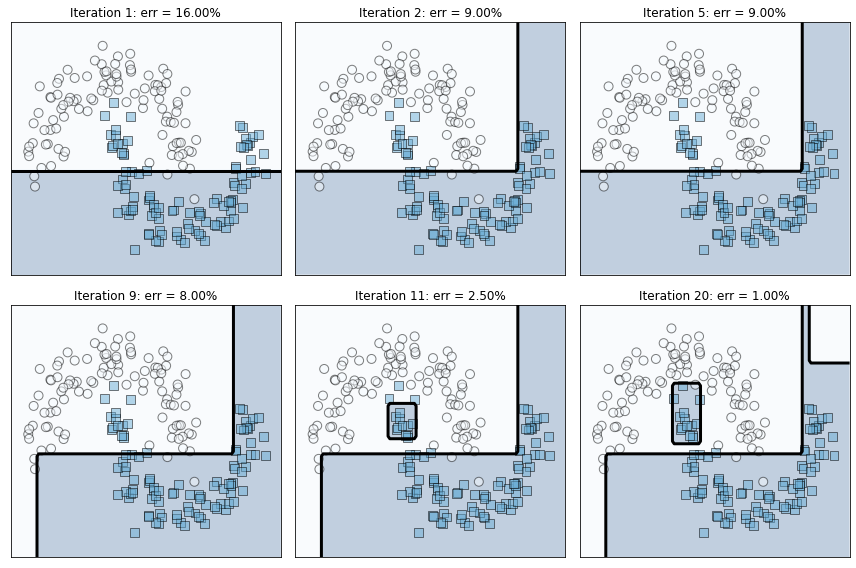

In [10]:
n_estimators = 20
estimators = []                  # Initialize an empty ensemble  
F = np.full((n_samples, ), 0.0)  # Predictions of each training example using the ensemble
                                  
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
subplot_id = -1
for t in range(n_estimators):
    # Fit a weak learner to the residuals, which are computed as gradient(Loss(y, F))
    residuals = y - F
    h = DecisionTreeRegressor(max_depth=1)
    h.fit(X, residuals)

    # Compute a step length that produces the best improvement in the loss
    hreg = h.predict(X)
    loss = lambda a: np.linalg.norm(y - (F + a * hreg))**2
    step = minimize_scalar(loss, method='golden')
    a = step.x

    # Update the ensemble predictions
    F += a * hreg

    # Update the ensemble
    estimators.append((a, h))

    # Plot the ensemble
    if t in [0, 1, 4, 8, 10, 19]:
        subplot_id += 1
        r, c = np.divmod(subplot_id, 3)
        err = (1 - accuracy_score(y, predict_gradient_boosting(X, estimators))) * 100

        title = 'Iteration {0}: err = {1:4.2f}%'.format(t + 1, err)
        plot_2d_classifier(ax[r, c], X, y, 
                           predict_function=predict_gradient_boosting, predict_args=estimators,
                           alpha=0.25, xlabel=None, ylabel=None, boundary_level=[0.0],
                           title=title, colormap='Blues', s=80)
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
        
fig.tight_layout()

---
### 5.2.3	Gradient Boosting with scikit-learn

``scikit-learn``’s [``GradientBoostingClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) provides additional functionality including support for multi-class classification, as well as other base learning algorithms beyond decision trees. 

#### Standard gradient boosting
The most important choice for ``GradientBoostingClassifier`` is the type of loss function. In our own hands-on implementation, we used the least-squares loss. ``GradientBoostingClassifier``, however, supports only the ``logistic`` and ``exponential`` loss functions. 

There are two other important arguments that the ``GradientBoostingClassifier`` takes (these are similar to the [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)):
* ``n_estimators``, the number of weak learners that will be trained sequentially by AdaBoost, and
* ``learning_rate``, an additional parameter that progressively shrinks the contribution of each successive weak learner

Unlike ``AdaBoostClassifier`` which supports several different types of base estimators, ``GradientBoostingClassifier`` is a tree-based ensemble and only uses decision trees as base estimators. We can control the depth of the base estimators with the ``max_depth`` parameter.

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25, random_state=13)

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
ensemble = GradientBoostingClassifier(max_depth=1, 
                                      n_estimators=20, learning_rate=0.75)
ensemble.fit(Xtrn, ytrn)

GradientBoostingClassifier(learning_rate=0.75, max_depth=1, n_estimators=20)

In [13]:
ypred = ensemble.predict(Xtst)
err = 1 - accuracy_score(ytst, ypred)
print(err)

0.04895104895104896


### 5.2.4 Histogram-based gradient boosting
During regression-tree learning, candidate splits are found as the feature-feature value combination that results in the greatest improvement according to some metric such as mean-squared loss. The most-commonly used split-finding algorithm explicitly enumerates all possible feature-feature values to identify the best one to split on. While extremely simple to implement, this exhaustive enumeration is highly inefficient for **large data sets**. 

A far more efficient approach is **bin-based splitting**, where feature values are re-organized into a small number of bins and the split is identified from among them. An efficient way to bin feature values is by constructing histograms. 

The figure below shows compares standard splitting used in decision tree learning and histogram-based splitting. Standard tree learning evaluates every possible split, which is illustrated a line between each pair of data points. The best split is the one with the lowest split criterion (here, squared loss). (right) Histogram-based binning first puts the data into 5 buckets, and then evaluates the splits between each pair of data buckets. Again, the best split is the one with the lowest split criterion (also squared loss).

(-0.32415723919361916, 0.03328129010590256)
(-1.414504320809411, 0.03656356170144992)


C:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


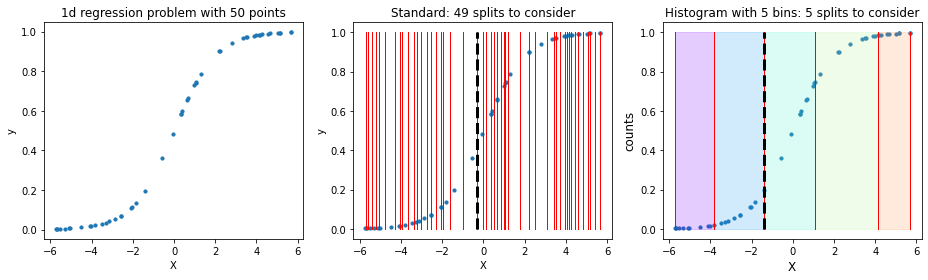

In [14]:
# Generate some random regression data
n_samples = 50
n_bins = 5
X = np.random.uniform(low=-6.0, high=6.0, size=(n_samples, ))
X = np.sort(X)
y = 1 / (1 + np.exp(-X))

# Plot the data
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))
ax[0].scatter(X, y, s=10)
ax[0].set_title('1d regression problem with {0} points'.format(n_samples))
ax[0].set_xlabel('X')
ax[0].set_ylabel('y')

# Plot the standard splits
ax[1].scatter(X, y, s=10)
for i in range(n_samples):
    split = (X[i] + X[i-1]) / 2
    ax[1].plot([split, split], [0.0, 1.0], c='r', linewidth=1)
ax[1].set_title('Standard: {0} splits to consider'.format(n_samples - 1))
ax[1].set_xlabel('X')
ax[1].set_ylabel('y')

# Identify the best split in the standard manner
best = (-np.inf, np.inf)
for i in range(n_samples):
    split = (X[i] + X[i-1]) / 2
    loss = np.mean((y[X <= split] - np.mean(y[X <= split]))**2) + np.mean((y[X > split] - np.mean(y[X > split]))**2)
    if loss <= best[1]:
        best = (split, loss)
print(best)
ax[1].plot([best[0], best[0]], [0., 1.], linewidth=3, linestyle='--', c='k')

# Plot the histogram splits
ax[2].scatter(X, y, s=10)
splits = np.interp(np.linspace(0, n_samples, n_bins + 1), np.arange(n_samples), X)
for split in splits:
    ax[2].plot([split, split], [0.0, 1.0], c='r', linewidth=1)
    
# bin_colors = get_colors(colormap='rainbow', n_colors=n_bins+1)    
cmap = cm.get_cmap('rainbow')
bin_colors = cmap(np.linspace(0, 1, num=n_bins+1))

for i in range(n_bins):
    ax[2].add_patch(patches.Rectangle((splits[i], 0.0), splits[i+1] - splits[i], 1.0, 
                                      color=col.rgb2hex(bin_colors[i]), alpha=0.2))   
ax[2].set_title('Histogram with {0} bins: {0} splits to consider'.format(n_bins), fontsize=12)
ax[2].set_xlabel('X', fontsize=12)
ax[2].set_ylabel('counts', fontsize=12)

# Identify the best histogram split
best = (-np.inf, np.inf)
splits = np.interp(np.linspace(0, n_samples, n_bins + 1), np.arange(n_samples), X)
for split in splits:
    loss = np.mean((y[X <= split] - np.mean(y[X <= split]))**2) + np.mean((y[X > split] - np.mean(y[X > split]))**2)
    if loss <= best[1]:
        best = (split, loss)
print(best)
ax[2].plot([best[0], best[0]], [0., 1.], linewidth=3, linestyle='--', c='k')

fig.tight_layout()
# plt.savefig('./figures/CH05_F17_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH05_F17_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

Histogram-bin construction can itself be slow if we have a very large number of data points. This can be further sped up by **downsampling** the data set cleverly. We are constructing a regression tree on the gradient data. A training example with a small gradient value has smaller weight, which means it is correctly classified and boosting need not worry about it. Alternately, a training example with a larger weight is incorrectly classified. 

Thus, if we downsample the data set such that it contains a higher percentage of training examples with larger gradients, then we can speed up histogram construction while focusing on the data points that matter most anyway. This is known as Gradient-based One Sided Sampling, or GOSS.

``scikit-learn`` 0.21 introduced the [``HistogramGradientBoostingClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) that implements histogram-based gradient boosting along with GOSS such that its training time is significantly improved. ``scikit-learn``'s version of histogram-based boosting is itself inspired by another implementation: [LightGBM](https://github.com/Microsoft/LightGBM) and is especially well-suited for large data sets. 

In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier

``HistGradientBoostingClassifier`` supports binary and multi-category ``logistic`` loss functions, respectively invoked with ``binary_crossentropy`` or ``categorical_crossentropy``. 

Similar to ``AdaBoostClassifier`` or ``GradientBoostingClassifier``, it also takes three other parameters:
* ``max_iter``, the number of weak learners that will be trained sequentially by AdaBoost, and
* ``learning_rate``, an additional parameter that progressively shrinks the contribution of each successive weak learner

Unlike ``AdaBoostClassifier`` it can also take a ``max_depth`` parameter, that specifies the maximum depth of the weak regression trees. Since deeper trees tend to be more complex and "stronger", ``max_depth`` allows us to control the "weakness" of the base estimators in the ensemble.

In [16]:
ensemble = HistGradientBoostingClassifier(max_depth=2, max_iter=20, learning_rate=0.75)
ensemble.fit(Xtrn, ytrn)

HistGradientBoostingClassifier(learning_rate=0.75, max_depth=2, max_iter=20)

In [17]:
ypred = ensemble.predict(Xtst)
err = 1 - accuracy_score(ytst, ypred)
print(err)

0.04195804195804198
